# Анализ результатов проведённого A/ B теста [Яндекс.Практикум]

# Подготовка данных для анализа

## Загрузка библиотек и данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import datetime as dt
import scipy.stats as stats


## Проверка данных о результатах тестирования на наличие пропущенных данных и дубликатов 

In [11]:
print('Общее количество строк с дубликатами в данных orders', orders[orders.duplicated(keep=False)].shape)
print('Общее количество вторых и последующих строк с дубликатами в данных orders', orders[orders.duplicated(keep='first')].shape)

print(' ')
print('Общее количество строк с дубликатами в данных visits', visitors[visitors.duplicated(keep=False)].shape)
print('Общее количество вторых и последующих строк с дубликатами в данных visits', visitors[visitors.duplicated(keep='first')].shape)


Общее количество строк с дубликатами в данных orders (0, 5)
Общее количество вторых и последующих строк с дубликатами в данных orders (0, 5)
 
Общее количество строк с дубликатами в данных visits (0, 3)
Общее количество вторых и последующих строк с дубликатами в данных visits (0, 3)


In [12]:
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [13]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

Полные дубликаты и пропущенные значения в данных не обнаружены

## Проверим, повторяются ли пользователи в группах A и B

In [14]:
len(orders) # количество строк в данных о заказах

1197

In [15]:
# Посчитаем количество уникальных строк в группах A и B
print('Количество уникальных пользователей в группе А', len(orders[orders['group'] =='A']['visitorId'].unique()))
print('Количество уникальных пользователей в группе B', len(orders[orders['group'] =='B']['visitorId'].unique()))

Количество уникальных пользователей в группе А 503
Количество уникальных пользователей в группе B 586


In [16]:
visitors_uniqueA = orders[orders['group'] =='A']['visitorId'].unique()
visitors_uniqueB = orders[orders['group'] =='B']['visitorId'].unique()
visitors_uniqueA # все номера пользователей из группы А

array([4069496402,   78758296,  295230930,  879864040, 3213223594,
       1565034404, 4227830084, 3207734412,   87885904,  199603092,
       3803269165, 2378935119,  834683205,  237748145, 1294108251,
       1471496742, 2735494018, 3251102545, 2978730290, 3660046170,
       1143609305, 2951649436,  343208965, 3055165772, 1422773200,
       2947100995, 3290315626, 2587526707,  787824685, 4099262874,
       1110543778, 3283584911, 3289144202, 3736064128, 2706377257,
        926057494, 1830791924,  381340408,  611059232, 1460891116,
       1722579998, 3379886002,  821846484, 4256040402, 2743474511,
       2038680547, 1430210707, 3213691396, 3722682546,  749770631,
       1738359350, 2254586615, 2458001652, 1211585711, 3967698036,
        678354126,  991436984, 1219079053,  572335325,  732900740,
       3891541246, 2874956069, 2892265953, 2303470071, 2583793022,
       1581167209, 1737494355, 2785040378,  876081193, 3123255051,
       1070130208, 1148665946,  138252163, 1129369369, 2668501

In [17]:
visitors_uniqueA_set = set(visitors_uniqueA)
visitors_uniqueB_set = set(visitors_uniqueB)
intersection = visitors_uniqueA_set & visitors_uniqueB_set
intersection_list = list(intersection)

print('Количество повторяющихся пользователей', len(intersection))

# получилось найти количество повторений с использованием set

Количество повторяющихся пользователей 58


58 пользователей попали и в группу A, и в группу B. 

Для дальнейшей работы с результатами A/B - тестирования, удалим данных пользователей

In [19]:
for i in range(len(orders['visitorId'])):
    if orders['visitorId'][i] in intersection_list:
        orders.drop(index = i, inplace=True)

In [20]:
len(orders) # осталось уникальных строк после удаления повторяющихся пользователей из групп А и B

1016

In [21]:
# Посчитаем количество уникальных строк в группах A и B
print('Количество уникальных пользователей в группе А', len(orders[orders['group'] =='A']['visitorId'].unique()))
print('Количество уникальных пользователей в группе B', len(orders[orders['group'] =='B']['visitorId'].unique()))

Количество уникальных пользователей в группе А 445
Количество уникальных пользователей в группе B 528


В группе B оказалось больше пользователей, это может сказаться на результатах A/B теста

## 1. Анализ графика кумулятивной выручки по группам

In [22]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


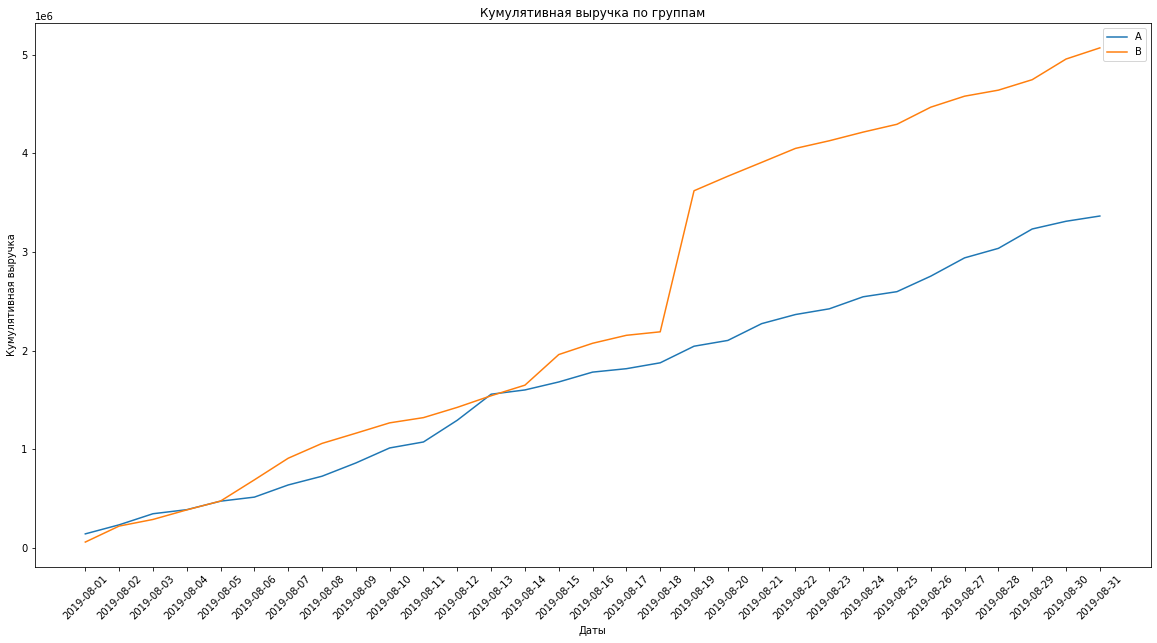

In [23]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(20, 10))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=45) 
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Даты')
plt.ylabel('Кумулятивная выручка')
plt.legend();

**Комментарий:**

Кумулятивная выручка по группам до 12 августа - росла со сходной динамикой. 17 августа произошел резкий рост выручки в группе B, после этого кумулятивная выручка продолжила расти со сходным темпом в обеих группах.

Есть предположение о том, что в группу B мог быть распределён клиенты с аномально высокой стоимостью заказа, которые сделали покупку 17 августа, что и отразилось на графике

## 2. Анализ графика кумулятивного среднего чека по группам

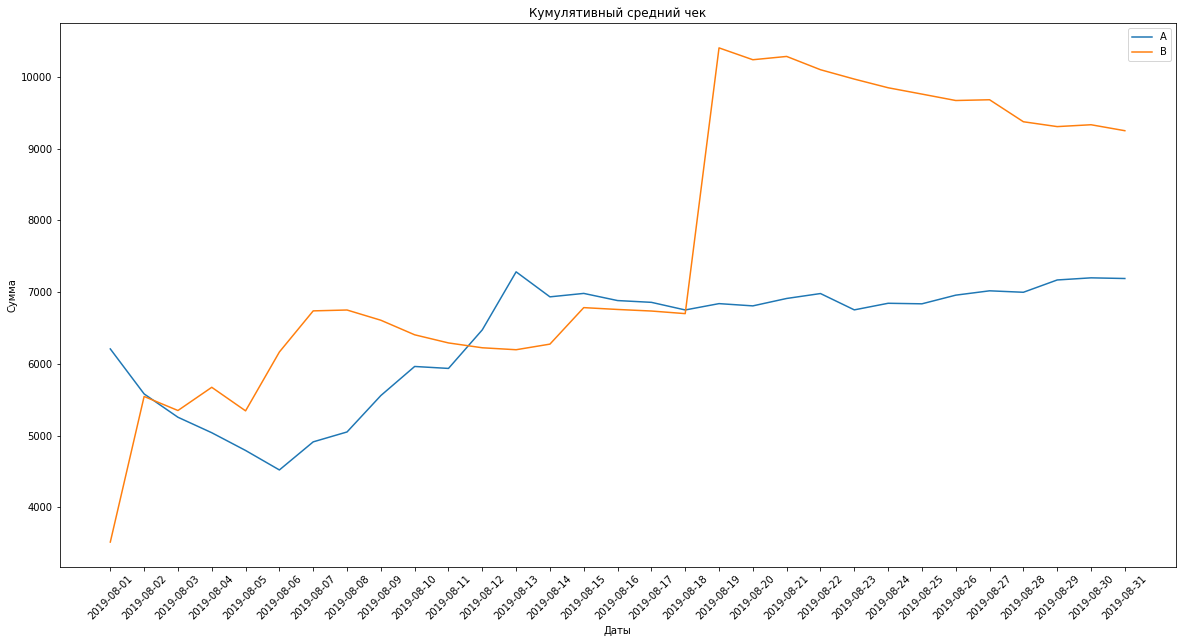

In [24]:
plt.figure(figsize=(20, 10))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45)
plt.title('Кумулятивный средний чек')
plt.xlabel('Даты')
plt.ylabel('Сумма')
plt.legend();

**Комментарий:**
    
По графику кумулятивного среднего чека до 17 августа наблюдается неоднозначная динамика по группам. 
В разные дни кумулятивный средний чек выше в то в одной, то в другой группе.

17 августа наблюдается резкий рост кумулятивного среднего чека в группе B. Далее кумулятивный средний чек в группе B плавно снижается, в группе A - плавно возрастает.
Возможно в группу B были распределены пользователи с аномально дорогими заказами или проводилась какая-либо акция, связанная с предметом исследования, которые попали в группу B

## 3. Анализ графика относительного изменения кумулятивного среднего чека группы B к группе A

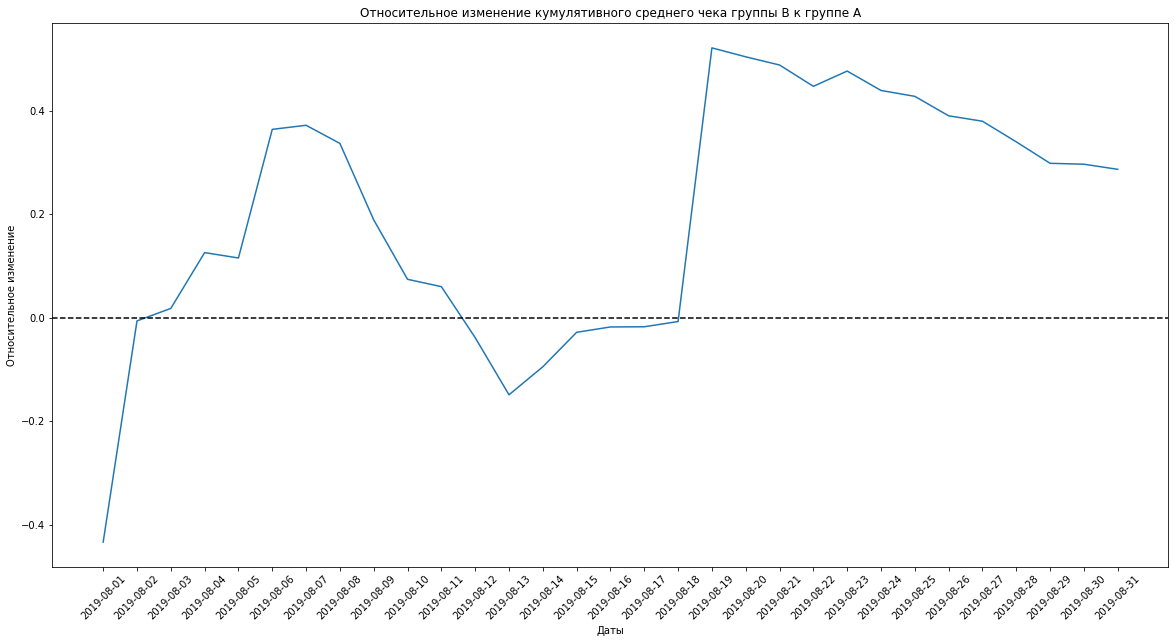

In [25]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(20, 10))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.xticks(rotation=45)
# добавляем ось X
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Даты')
plt.ylabel('Относительное изменение')
plt.axhline(y=0, color='black', linestyle='--');

**Комментарий:**

График различия между группами показывает волнообразную динамику. То выраженное увеличение среднего чека в группе B по сравнению с группой А. То, преимущество группы А. Причем после пика различия между группами A и B снижаются

## 4. Анализ графика кумулятивной конверсии по группам

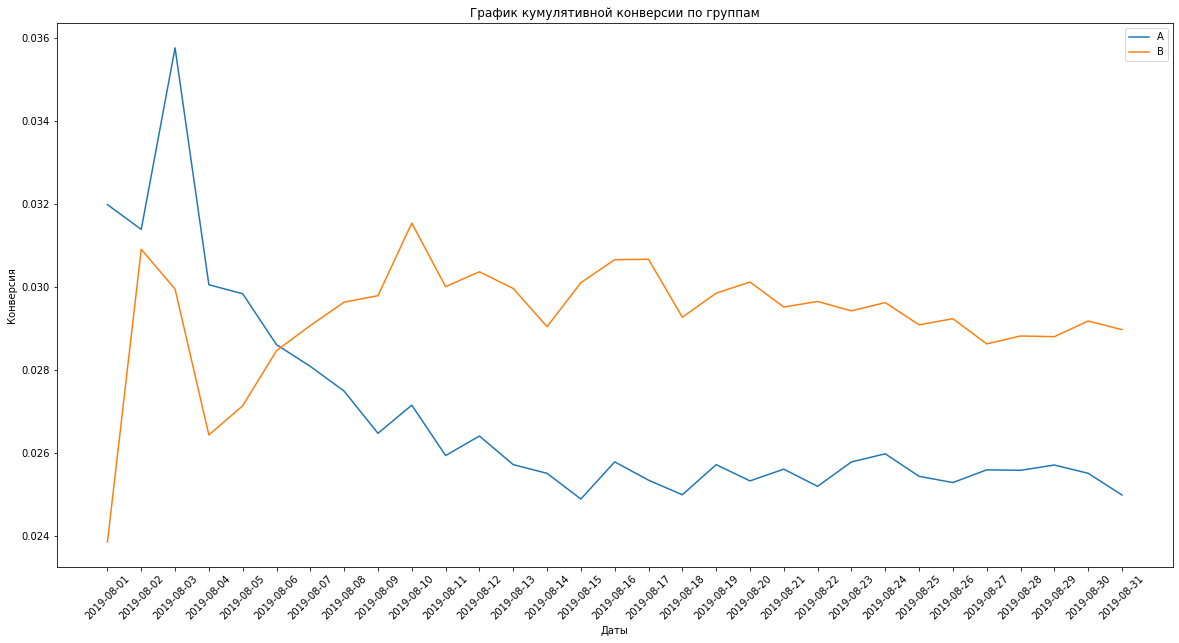

In [26]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(20, 10))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.xticks(rotation=45)
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Даты')
plt.ylabel('Конверсия')
plt.legend();

**Комментарий:**

До 06 августа значения конверсии в группах колебались. После 06 августа конверсия  в группе B стала стабильно превышать конверсию в группе А. То есть большее количество посетителей из группы B делали заказ, по сравнению с посетителями группы А.


## 5. Анализ графика относительного изменения кумулятивной конверсии группы B к группе A

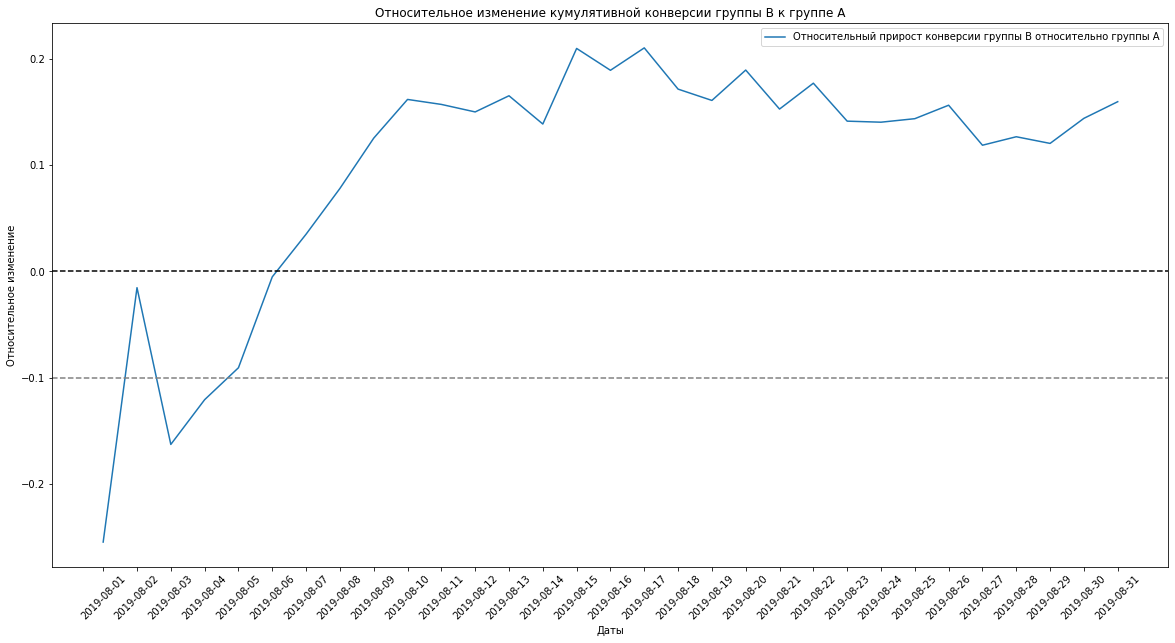

In [27]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(20, 10))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.xticks(rotation=45)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.title('Относительное изменение кумулятивной конверсии группы B к группе А')
plt.xlabel('Даты')
plt.ylabel('Относительное изменение')
plt.legend();

**Комментарий:**
    
После 05 августа конверсия в группе B стабильно превышает конверсию в группе А

## 6. Анализ точечного графика количества заказов по пользователям

In [28]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

         userId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


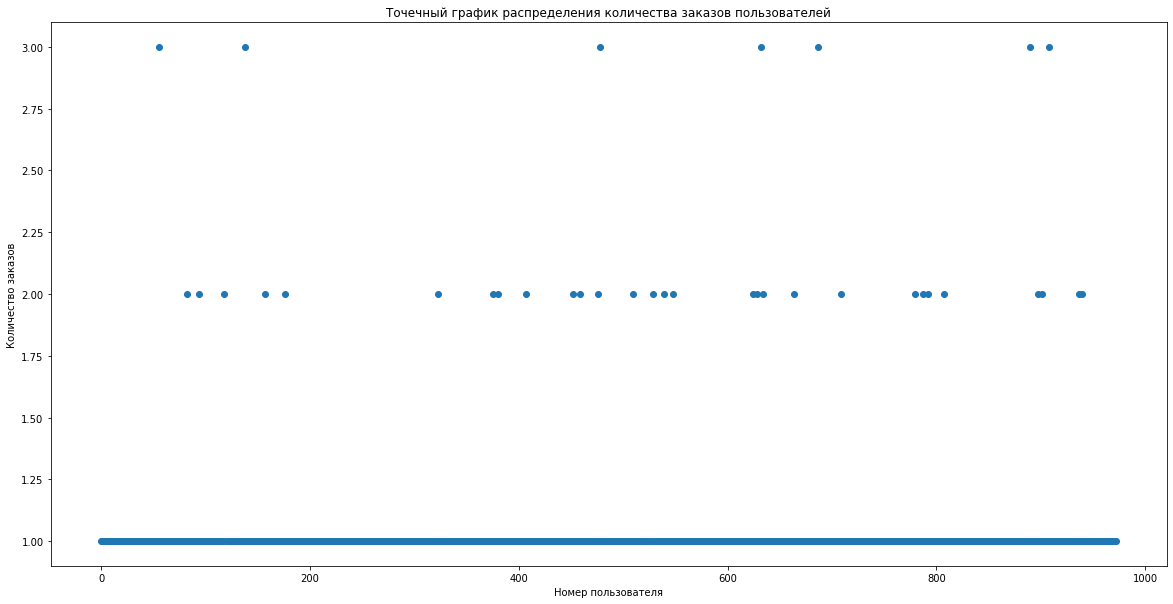

In [29]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(20, 10))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Точечный график распределения количества заказов пользователей')
plt.xlabel('Номер пользователя')
plt.ylabel('Количество заказов');

**Комментарий:**

На точечном графике мы видим, что большинство пользователей делает одну покупку, часть пользователей - две.
И только единичные пользователи совершают более 2 покупок

## 7.  Расчёт 95-ого и 99-ого перцентиля количества заказов на пользователя. Определение границы аномальных пользователей.

In [30]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) # аномальный пользователь - 2 и более заказов

[1. 1. 2.]


**Комментарий:**
    
С учётом точечного графика количества заказов и рассчитанных перцентилей, предлагаю рассматривать в качестве аномальных 2 и более заказа, поскольку их доля составляет не более 5% 

## 8. Анализ точечного графика стоимостей заказов

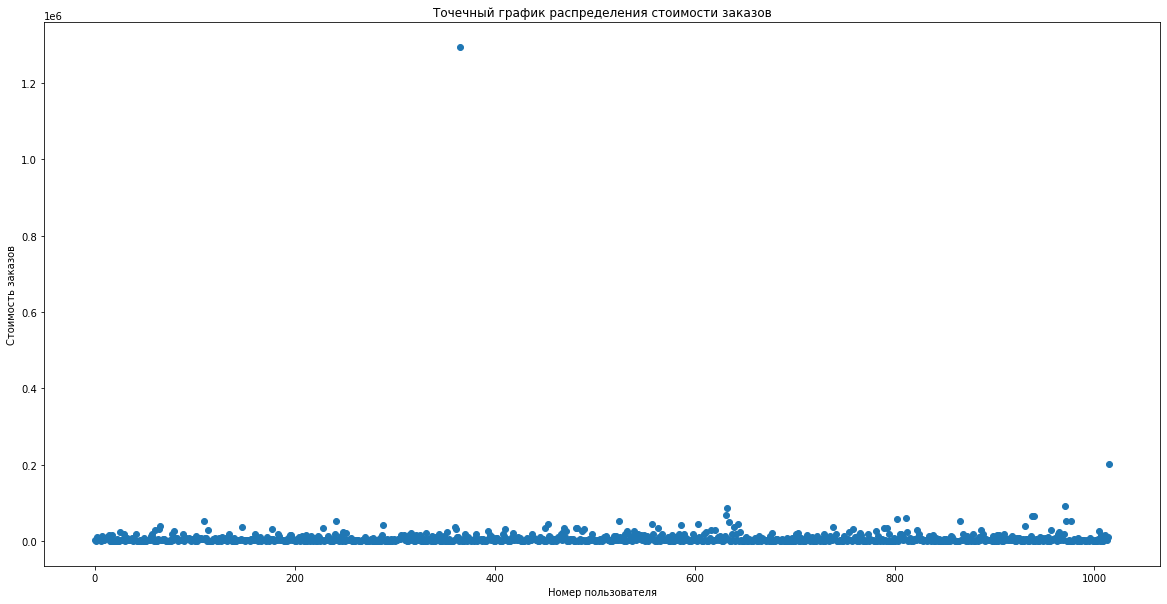

In [31]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(20, 10))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечный график распределения стоимости заказов')
plt.xlabel('Номер пользователя')
plt.ylabel('Стоимость заказов');

In [32]:
orders['revenue'].mean()

8300.814960629921

In [33]:
orders['revenue'].median()

2955.0

In [34]:
orders['revenue'].agg([max, min])

max    1294500
min         50
Name: revenue, dtype: int64

**Комментарий:**
    
Судя по графику стоимость большинства заказов не превышают 20000. При этом есть отдельные заказы существенно превышающие эту сумму, например, на 1 294 500 рублей (стоимость максимального заказа)

## 9. Расчёт 95-ого и 99-ого перцентиля стоимости заказов. Определение границы для  аномальных заказов.

In [35]:
print(np.percentile(orders['revenue'], [90, 95, 99])) ## граница стоимости аномальных заказов более 26785 рублей

[17990. 26785. 53904.]


**Комментарий:**

90% заказов попадают в диапазон до 17990 рублей. Только 1% заказов  оказываются выше 53904. Предлагаю рассматривать в качестве типовых заказов все на сумму не более 26785, чтобы не терять более 5% от количества заказов

## 10. Анализ статистической значимости различий в конверсии между группами по «сырым» данным

Для проверки статистической значимости применим критерии Манна-Уитни. Выберем уровень статистической значимости - 5%

**Нулевая гипотеза:**   
Конверсия между группами теста не отличается


**Альтернативная шипотеза:**   
Конверсия между группами теста значимо отличается при альфа = 0.05

In [36]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

         date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0  2019-08-01              23           142779              17   
1  2019-08-02              19            91602              23   
2  2019-08-03              24           112473              14   
3  2019-08-04              11            41176              14   
4  2019-08-05              22            86383              21   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0            59758                  23               142779   
1           162043                  42               234381   
2            67049                  66               346854   
3            96890                  77               388030   
4            89908                  99               474413   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17                59758               719   
1                  40               221801               619   
2                  54           

In [38]:
#'transactionId', 'visitorId'
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value при проверке значимости различий конверсии между группами', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print(f"Относительно изменение конверсии: {sampleB.mean() / sampleA.mean() - 1:.1%}")

p-value при проверке значимости различий конверсии между группами 0.006
Относительно изменение конверсии: 16.0%


**Комментарий:**

По результатам статистического теста на основе "сырых" данных подтвердились значимые различии в конверсии пользователей в группе В, которое наблюдалось на графиках

In [39]:
# КОД РЕВЬЮВЕРА
print(f"Относительно изменение конверсии: {sampleB.mean() / sampleA.mean() - 1:.1%}")


Относительно изменение конверсии: 16.0%


## 11. Анализ статистической значимости различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

Для проверки статистической значимости применим критерии Манна-Уитни. Выберем уровень статистической значимости - 5%

**Нулевая гипотеза:**   
Средний чек между группами теста не отличается


**Альтернативная шипотеза:**   
Есть различия между группами в размере среднего чека

In [40]:
print('p-value при проверке значимости различий в размере среднего чека между группами', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост в размере среднего чека для группы B по сравнению с группой А','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value при проверке значимости различий в размере среднего чека между группами 0.415
Относительный прирост в размере среднего чека для группы B по сравнению с группой А 0.287


**Комментарий:**
    
При этом на основане "сырых" данных не выявлено статистически значимых различий между группами в средней стоимости заказов

## 12. Анализ статистической значимости различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.

Для проверки статистической значимости применим критерии Манна-Уитни. Выберем уровень статистической значимости - 5%

**Нулевая гипотеза:**   
Конверсия между группами теста не отличается при использовании "очищенных" данных


**Альтернативная шипотеза:**   
Конверсия между группами теста значимо отличается при альфа = 0.05 (при использовании очищенных данных)

In [41]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 1]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 1]['userId'],
    ],
    axis=0,
)

REVENUE_THRESHOLD = int(orders['revenue'].quantile(0.95))

usersWithExpensiveOrders = orders[orders['revenue'] > REVENUE_THRESHOLD]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print('Количество аномальных пользователей с заданными критериями (более 1 заказа, на сумму более 26785)', abnormalUsers.shape[0]) 

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64
Количество аномальных пользователей с заданными критериями (более 1 заказа, на сумму более 26785) 86


**Комментарий:**

Получено 86 аномальных пользователей, при ограничении - более 1 заказа стоимостью более 26785.    
Получено 58 аномальных пользователей, при ограничении - более 2 заказа стоимостью более 26785.

Продолжим анализ с более строгим ограниченеим, исключим 86 пользователей.

In [42]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [43]:
print('p-value при проверке значимости различий конверсии между группами на очищенных данных', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print(f"Относительно изменение конверсии при использовании очищенных данных: {sampleBFiltered.mean() / sampleAFiltered.mean() - 1:.1%}")

p-value при проверке значимости различий конверсии между группами на очищенных данных 0.008
Относительно изменение конверсии при использовании очищенных данных: 17.4%


**Комментарий:**

Подтверждены значимые различия в конверсии между двумя группами после удаления 86 аномальных пользователей

## 13. Анализ статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

Для проверки статистической значимости применим критерии Манна-Уитни. Выберем уровень статистической значимости - 5%

**Нулевая гипотеза:**   
Средний чек между группами теста не отличается


**Альтернативная шипотеза:**   
Есть различия между группами в размере среднего чека

In [44]:
print('p-value при проверке значимости различий в размере среднего чека между группами на очищенных данных',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительное различие в среднем чеке между группами на очищенных данных',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-value при проверке значимости различий в размере среднего чека между группами на очищенных данных 0.364
Относительное различие в среднем чеке между группами на очищенных данных -0.034


**Комментарий:**

После удаления аномальных пользователей не выявлены значимые различия между группами A и B по средней стоимости заказа. 


## 14. Предложение о решении по результатам теста 

## Описание результатов анализа A/B-теста:

1. Выявлены пользователи, которые попали одновременно в обе группы. Пользователи были исключены из анализа, общее количество данных сократилось приблизительно на 10%


2. В группе B после удаления одинаковых пользователей, больше участников, чем в группе А. Различия в численности групп могут сказываться на результатах статистических тестов


3. В группу B попал пользователь с заказом более 1 млн.рублей, что искажает расчет кумулятивных данных


4. На "сырых" и "очищенных" данных выявлено значимое отличие между конверсией в двух группах. В группе B - конверсия значимо выше


5. На "сырых" и "очищенных" данных НЕ выявлено значимых различий между средней стоимостью заказа.
    
    
**Вывод:**
Поскольку анализ проводится не на уникальных пользователях, а на данных посещений, можно остановить тест и использовать имеющиеся данные для получения выводов. Поскольку конверсия в группе B выше при той же стоимости заказа, компания получает больше выручки. Далее оправдано применение пользовательского пути, который предлагался группе B
